In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import re

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from skbio.stats.composition import clr

In [4]:
import data_loaders 
import target_loaders
import viz_utils
import evaluation

## Setting: loading the data, define the samples, etc.

In [27]:
relative_abundance = data_loaders.load_taxa_in_relative_abundance()
read_count = data_loaders.load_taxa_in_read_count()

age_gender = data_loaders.load_age_and_gender_data()
bmi_data = data_loaders.load_bmi_data()

trig = target_loaders.load_triglyceride()
trig_at_risk = target_loaders.load_triglyceride_at_risk()
log_trig = trig.apply(lambda x: np.log(x))

samples = bmi_data.dropna().index.intersection(trig.dropna().index).intersection(read_count.dropna().index)
compromise_subjects = data_loaders.load_medication_per_subject_filter()
print(f"filtering {compromise_subjects.shape[0]} subject out of "samples.shape[0]" due to medication")
samples = samples.difference(compromise_subjects)
print(f"This analysis will include: {samples.shape[0]} subjects")

relative_abundance = relative_abundance.loc[samples, :]
read_count = read_count.loc[samples, :]
age_gender = age_gender.loc[samples, :]
bmi_data = bmi_data.loc[samples, :]
trig = trig.loc[samples]
trig_at_risk = trig_at_risk.loc[samples]
log_trig = log_trig.loc[samples]


Species that at least 10 % of the samples have relative abundance above the threshold: 0.001
305 out of 52648 species, aka 0.58%


/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/Lifeline/data_loaders.py:28: DtypeWarning: Columns (7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,87,88,89,90,91,92,93,94,97,98,99,100,101,102,103,104,107,108,109,110,111,112,113,114,117,118,119,120,121,122,123,124,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,195,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,259,366,367,368,369,370,371,423,424,425,426,427,428,446,447,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,470,475) have mixed types. Specify dtype optio

<Axes: ylabel='Frequency'>

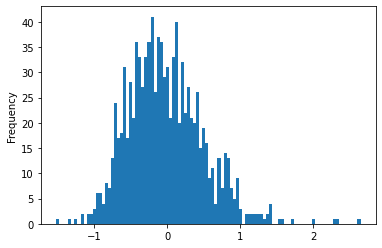

In [28]:
log_trig.plot.hist(bins=100)

In [30]:
# Add psuedo count to handle the assumption for positive-only
PSUEDO_COUNT = 1
clr_taxa = clr(read_count+PSUEDO_COUNT)
clr_taxa= pd.DataFrame(clr_taxa, index=read_count.index, columns=read_count.columns)

Text(0.5, 1.0, 'max')

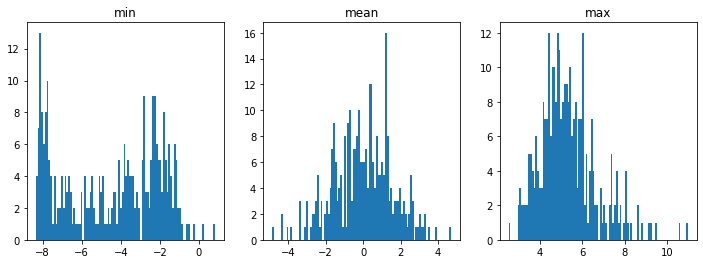

In [31]:
# Vis:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].hist(clr_taxa.min(), bins=100)
axes[0].set_title('min')
axes[1].hist(clr_taxa.mean(), bins=100)
axes[1].set_title('mean')
axes[2].hist(clr_taxa.max(), bins=100)
axes[2].set_title('max')

 Let's preform PCA on the CLR data to get PCoA with aitchison distance:
 
 We will try to explain to trig at risk using the top component 
 
 Can it explain about BMI and Gender (and age, but this is mainor contributer)? 
 
 We will try to use both RandomForest and Logitic Regression to answer this question. 

In [8]:
# Define the target:
y = trig_at_risk

# Define the features:
X = pd.concat([clr_taxa, age_gender, bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train.head()

,Ruminiclostridium_E siraeum,CAG-1427 sp000435675,Blautia_A faecis,Tidjanibacter inops_A,Gemmiger qucibialis,Collinsella sp900556515,UMGS1375 sp900066615,Bacteroides intestinigallinarum,Acetatifactor intestinalis,Butyribacter sp003529475,...,Agathobacter rectalis,Prevotella sp003447235,Prevotella sp900546535,Prevotella hominis,Prevotella sp900556795,Cryptobacteroides sp000433355,Limisoma sp000437795,age,bmi,FEMALE
LLDeep_0760,-0.002558,-0.002746,0.001381,-0.002737,0.000951,0.014456,-0.002607,0.000049,-0.001663,0.002847,...,0.027946,-0.002745,-0.002743,-0.002742,-0.002734,-0.002743,-0.002738,22.0,26.861207,0
LLDeep_1207,-0.001547,-0.002096,0.002507,-0.001490,0.006308,-0.001370,0.003137,-0.002248,-0.001885,-0.002014,...,-0.001613,-0.002284,-0.002182,-0.002229,-0.002244,-0.002275,-0.001165,64.0,24.599409,0
LLDeep_0101,-0.001730,-0.002758,0.002325,-0.002753,0.009232,-0.002172,-0.002505,-0.002235,0.000289,0.005498,...,-0.002537,-0.002747,-0.002488,-0.002609,-0.002657,-0.002758,-0.002758,41.0,30.870026,0
LLDeep_0598,0.012761,-0.002224,0.000191,-0.000689,0.014536,-0.001574,0.001890,-0.001992,0.002549,-0.000740,...,0.015287,-0.002183,-0.001569,0.000779,-0.001864,-0.002251,-0.002249,31.0,19.839716,1
LLDeep_0721,-0.002623,-0.002628,0.000894,-0.002296,0.010097,-0.002323,-0.002490,-0.001639,-0.002522,-0.002578,...,0.031414,-0.002629,-0.002629,-0.002629,-0.002626,-0.002629,-0.002629,37.0,26.716141,0


In [11]:
# Let's preform PCA on the CLR data to get PCoA with aitchison distance
from sklearn.decomposition import PCA
clr_taxa_train = clr_taxa.loc[X_train.index, :]
pca = PCA()
pca_train = pca.fit_transform(clr_taxa_train)
pca_train = pd.DataFrame(pca_train, index=X_train.index)
pca_train.columns= pca_train.columns.map(lambda x: f'PC{x+1}')

## viz:

In [12]:
# Let's try to understand better the PCA by looking at the explained variance:
print(pca.explained_variance_ratio_[:10])

[0.1750455  0.08444908 0.06813597 0.04734455 0.04273289 0.03678214
 0.03150437 0.02799464 0.02628048 0.02357776]


In [13]:
pd.Series(pca.explained_variance_ratio_.cumsum())

0      0.175046
1      0.259495
2      0.327631
3      0.374975
4      0.417708
         ...   
300    0.999999
301    0.999999
302    1.000000
303    1.000000
304    1.000000
Length: 305, dtype: float64

In [14]:
pca.explained_variance_ratio_.cumsum()[50]

np.float64(0.8614151537915729)

In [15]:
pca.explained_variance_ratio_[0].round(2)

np.float64(0.18)

Seems like the first component explain 91% of the variance and the first two component explain > 99% of the variance.

<Axes: xlabel='PC1', ylabel='trig'>

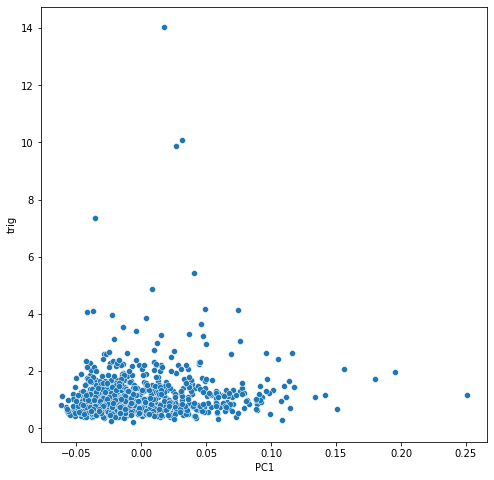

In [16]:
# Plot trig levels vs. top component 
# Scatter plot of trig vs. the first component
plt.figure(figsize=(8, 8))
sns.scatterplot(data=pd.DataFrame({'log_trig': log_trig.loc[pca_train.index], 'PC1': pca_train.iloc[:, 0]}), x='PC1', y='log_trig')

Text(0, 0.5, 'PC2 (explained variance 0.08 %)')

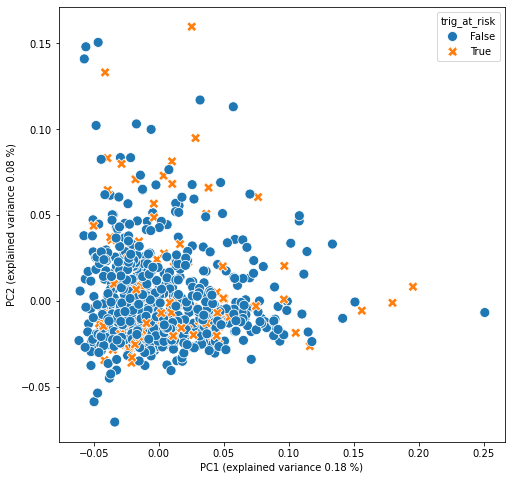

In [17]:
# Scatter plot of the first & second component colored by trig_at_risk yes/no
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=pd.DataFrame({'trig_at_risk': trig_at_risk.loc[pca_train.index], 'PC1': pca_train.iloc[:, 0], 'PC2': pca_train.iloc[:, 1]}),
                x='PC1', y='PC2', hue='trig_at_risk', style='trig_at_risk', s=100)
ax.set_xlabel(f'PC1 (explained variance {pca.explained_variance_ratio_[0].round(2)} %)')
ax.set_ylabel(f'PC2 (explained variance {pca.explained_variance_ratio_[1].round(2)} %)')


<Axes: xlabel='PC2', ylabel='Count'>

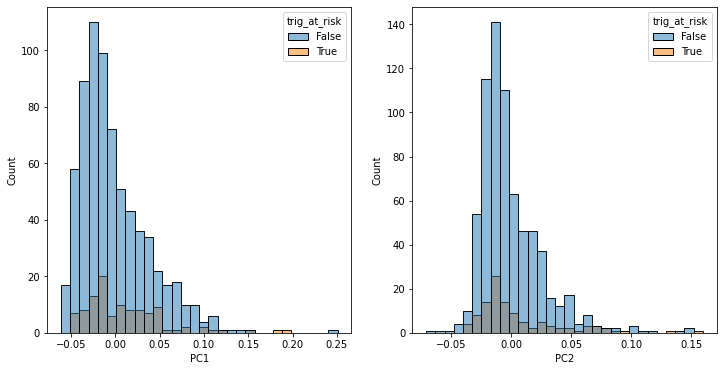

In [18]:
# Plot PCA1 distribution given trig at risk: 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(data=pd.DataFrame({'PC1': pca_train.iloc[:, 0], 'trig_at_risk': trig_at_risk}), x='PC1', hue='trig_at_risk', bins=30, ax=axes[0])
sns.histplot(data=pd.DataFrame({'PC2': pca_train.iloc[:, 1], 'trig_at_risk': trig_at_risk}), x='PC2', hue='trig_at_risk', bins=30,  ax=axes[1])

## Prediction using PCA 

We will try to use the microbiome top PCA component (PC1 and PC2) to imporve the prediction model. 
We will try both RF and Logistic Regression for the trig at risk.

(Should we also try Linear Regression model or GLM for the trig levels. ?)

In [19]:
ft_train = pd.concat([X_train[['age', 'FEMALE', 'bmi']], pd.DataFrame({'PC1':pca_train.iloc[:, 0], 'PC2':pca_train.iloc[:, 1]})], axis=1)

In [20]:
ft_train.head()

,age,FEMALE,bmi,PC1,PC2
LLDeep_0760,22.0,0,26.861207,0.012363,-0.022081
LLDeep_1207,64.0,0,24.599409,-0.023028,-0.013561
LLDeep_0101,41.0,0,30.870026,0.089446,-0.010614
LLDeep_0598,31.0,1,19.839716,-0.013064,-0.016447
LLDeep_0721,37.0,0,26.716141,0.011373,0.002720


In [21]:
# random_forest = RandomForestClassifier(random_state=42)

# param_grid = {'n_estimators': [50, 100],
#               'max_depth': [None, 3, 10],
#               'min_samples_split': [2, 10, 50],
#    'max_features': ['sqrt', 'log2'],
#              'class_weight': [None, 'balanced']}

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
# search.fit(ft_train, y_train)

# print(search.best_params_)

# clf = RandomForestClassifier(random_state=42, **search.best_params_)
# clf.fit(ft_train, y_train)

In [22]:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}

random_forest = RandomForestClassifier(random_state=42)
clf = RandomForestClassifier(random_state=42, **params)
clf.fit(ft_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

In [23]:
# To evaluate:
clr_taxa_test = clr_taxa.loc[X_test.index, :]
pca_test = pca.transform(clr_taxa_test)
pca_test = pd.DataFrame(pca_test, index=X_test.index)
pca_test.columns= pca_test.columns.map(lambda x: f'PC{x+1}')

ft_test = pd.concat([X_test[['age', 'FEMALE', 'bmi']], pd.DataFrame({'PC1':pca_test.iloc[:, 0], 'PC2':pca_test.iloc[:, 1]})], axis=1)

              precision    recall  f1-score   support

       False       0.94      0.71      0.81       175
        True       0.27      0.70      0.39        27

    accuracy                           0.71       202
   macro avg       0.61      0.71      0.60       202
weighted avg       0.85      0.71      0.75       202



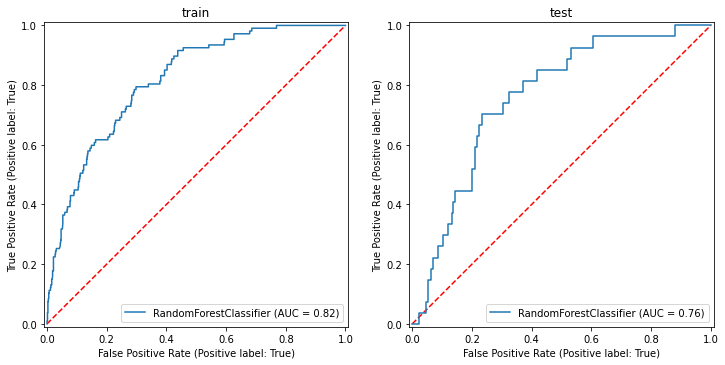

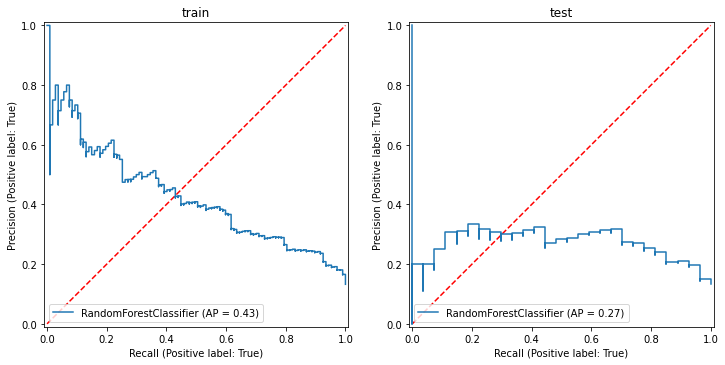

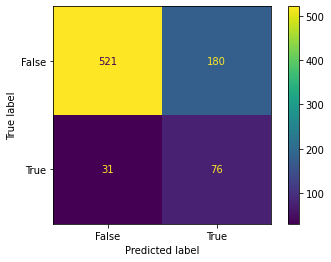

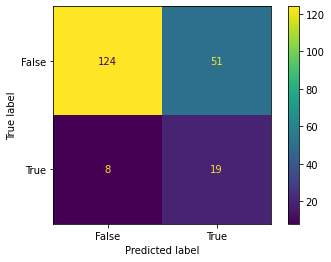

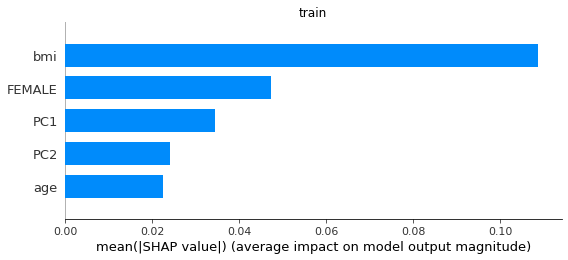

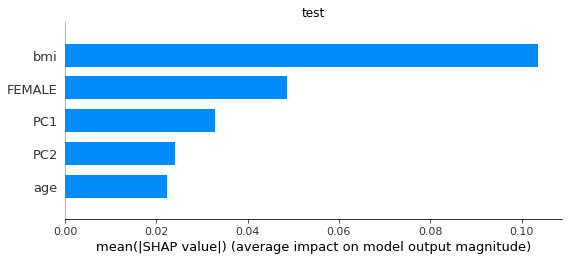

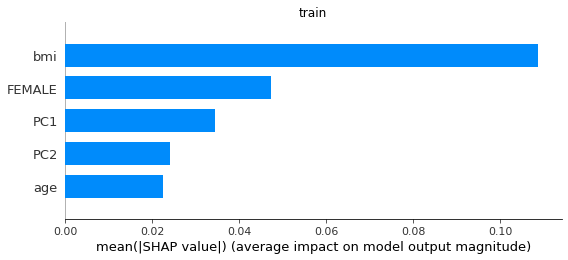

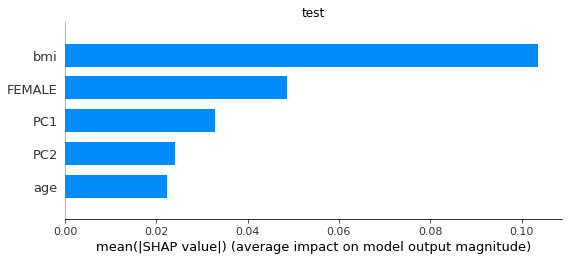

In [24]:
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

In [27]:
# The baseline on the exact same samples:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}
baseline_ft_train = ft_train[['age', 'FEMALE', 'bmi']]

random_forest = RandomForestClassifier(random_state=42)
baseline = RandomForestClassifier(random_state=42, **params)
baseline.fit(baseline_ft_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

              precision    recall  f1-score   support

       False       0.96      0.66      0.78       175
        True       0.27      0.81      0.40        27

    accuracy                           0.68       202
   macro avg       0.61      0.74      0.59       202
weighted avg       0.87      0.68      0.73       202



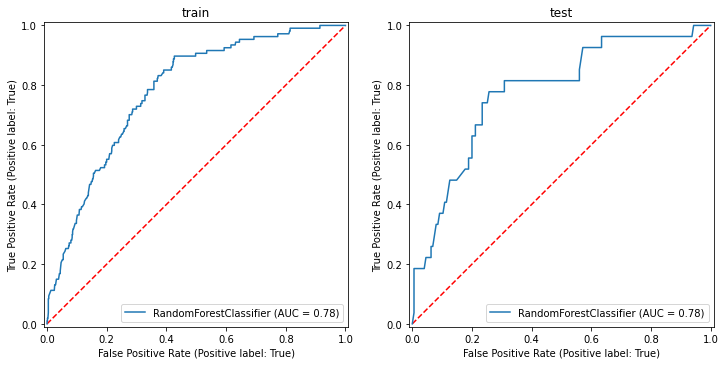

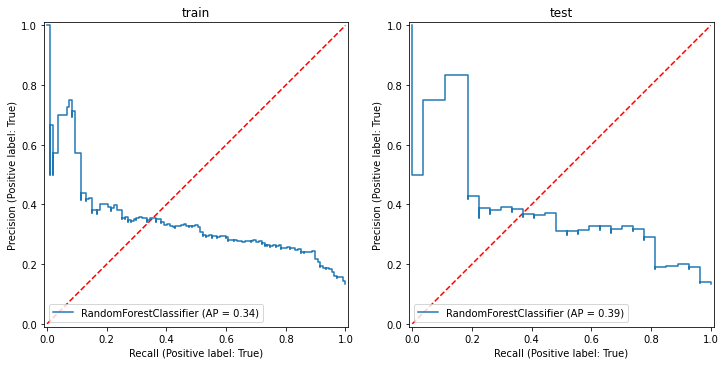

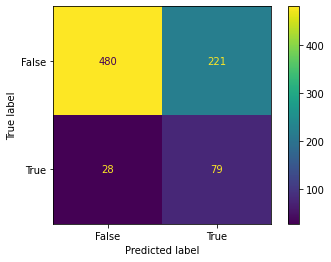

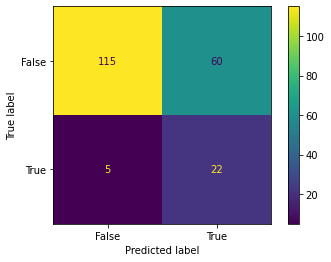

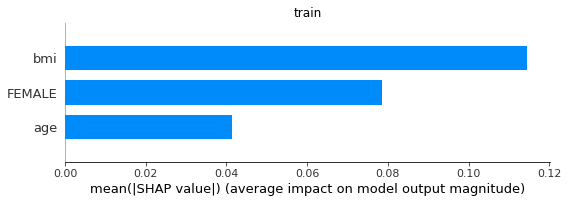

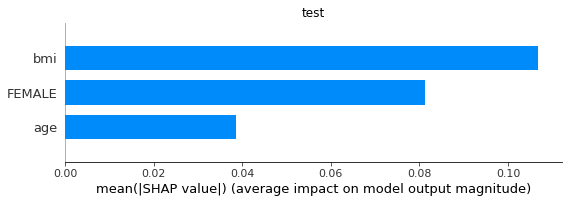

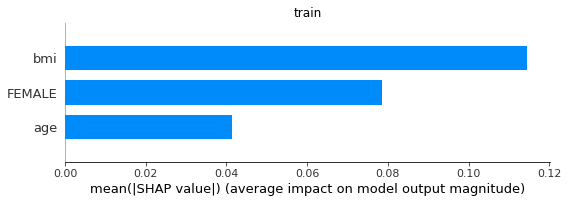

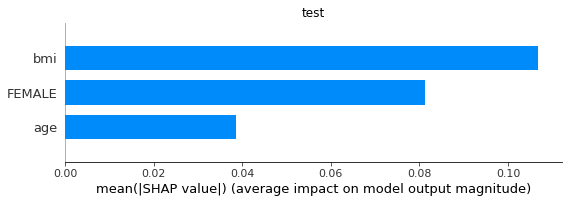

In [28]:
baseline_ft_test = ft_test[['age', 'FEMALE', 'bmi']]
evaluation.report_clf_preformance(clf=baseline, X_train=baseline_ft_train, y_train=y_train, X_test=baseline_ft_test, y_test=y_test)

In [43]:
# Now lets try with the top 50 PCA (together > 95% of explained variance) and using hyper-parameter tunning and see if it helps:
ft_train = pd.concat([X_train[['age', 'FEMALE', 'bmi']], pca_train[[f'PC{x}' for x in range(1, 51)]]], axis=1)
random_forest = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10, 50],
               'max_features': ['sqrt'],
             'class_weight': ['balanced']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(ft_train, y_train)

print(search.best_params_)

clf = RandomForestClassifier(random_state=42, **search.best_params_)
clf.fit(ft_train, y_train)

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=50, random_state=42)

              precision    recall  f1-score   support

       False       0.86      0.99      0.92       175
        True       0.00      0.00      0.00        27

    accuracy                           0.86       202
   macro avg       0.43      0.49      0.46       202
weighted avg       0.75      0.86      0.80       202



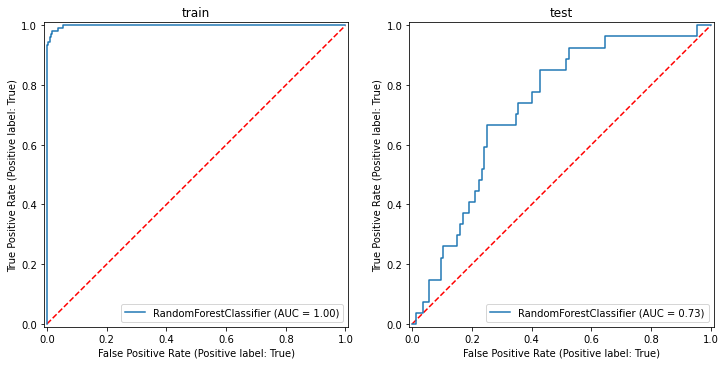

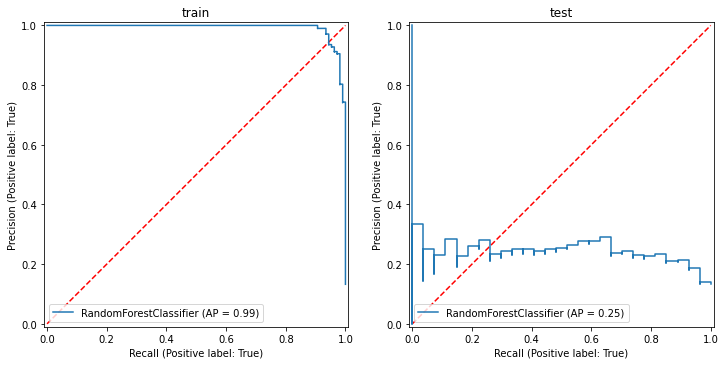

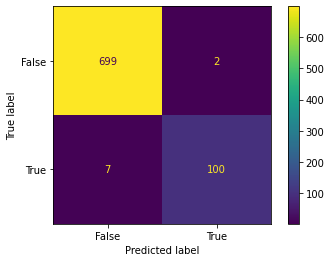

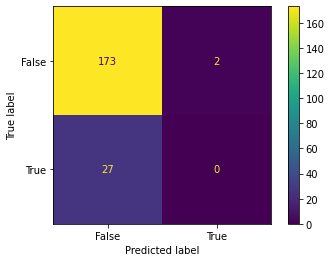

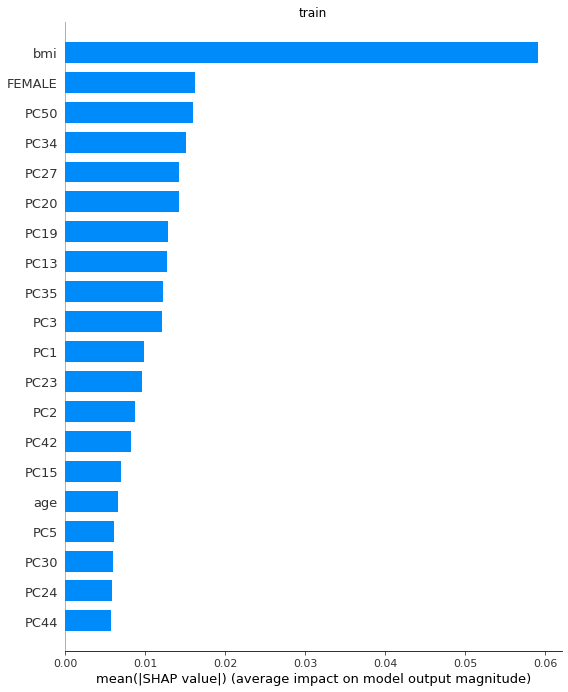

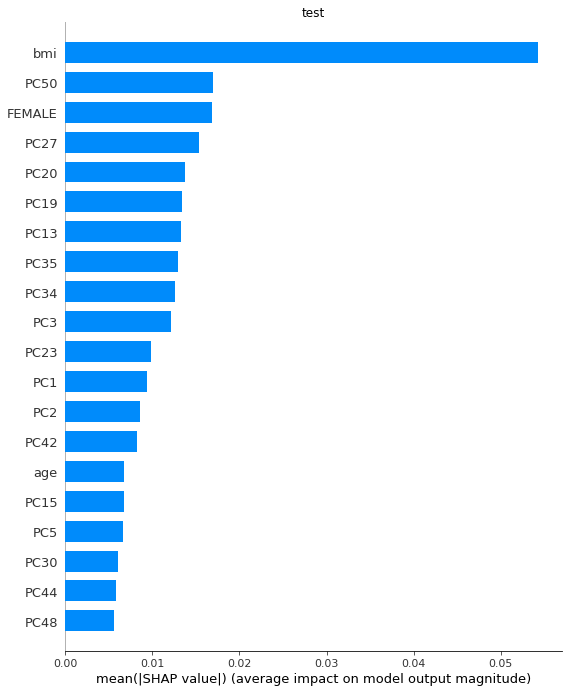

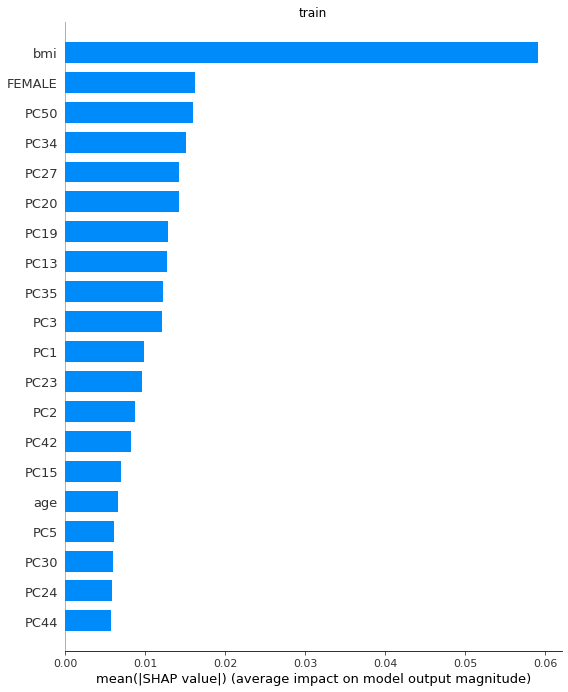

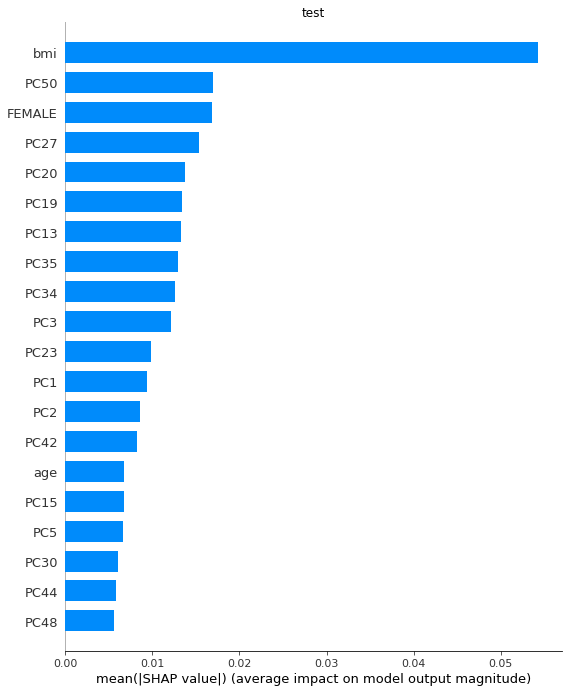

In [44]:
ft_test = pd.concat([X_test[['age', 'FEMALE', 'bmi']], pca_test[[f'PC{x}' for x in range(1, 51)]]], axis=1)
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

Seems like we significantly overfitting, even due we try to use cross validation to avoid it. 
Let's try to manually select the same parameters as the baseline:

In [45]:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}

random_forest = RandomForestClassifier(random_state=42)
clf = RandomForestClassifier(random_state=42, **params)
clf.fit(ft_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

              precision    recall  f1-score   support

       False       0.89      0.88      0.89       175
        True       0.28      0.30      0.29        27

    accuracy                           0.80       202
   macro avg       0.58      0.59      0.59       202
weighted avg       0.81      0.80      0.80       202



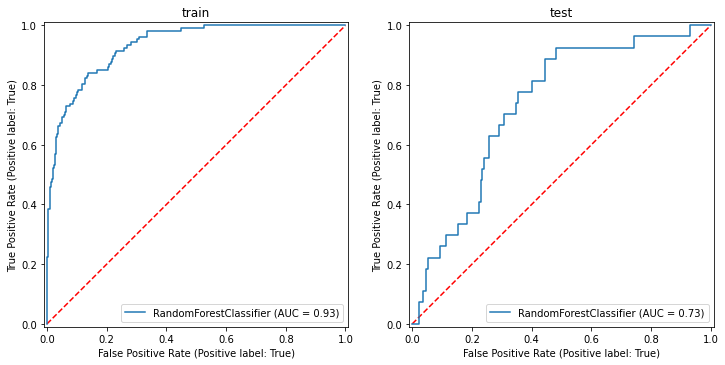

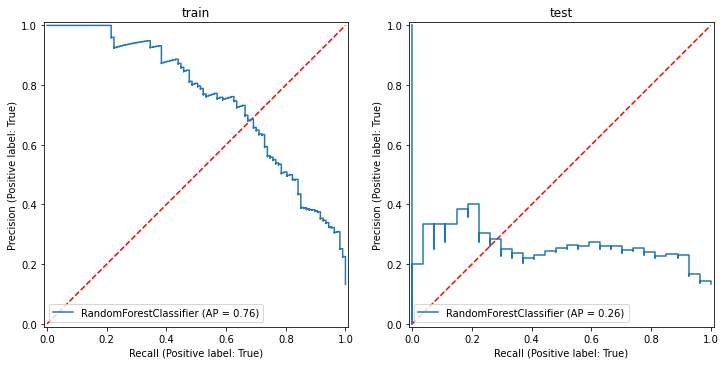

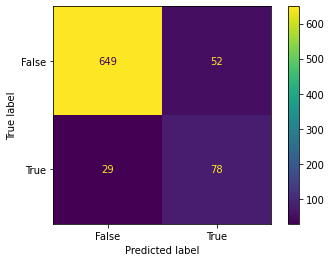

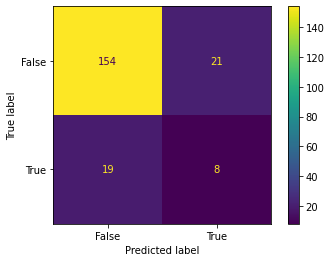

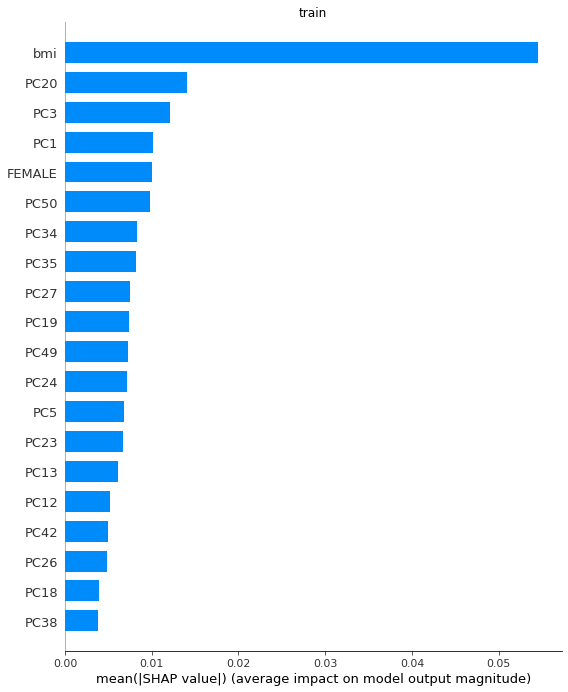

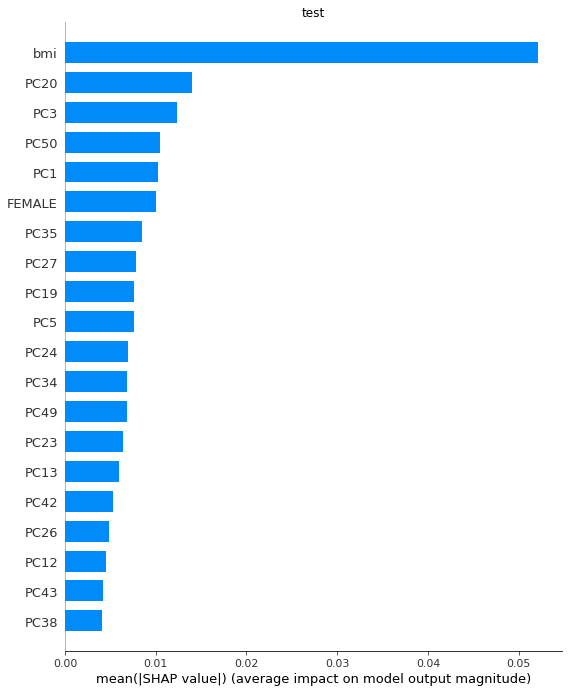

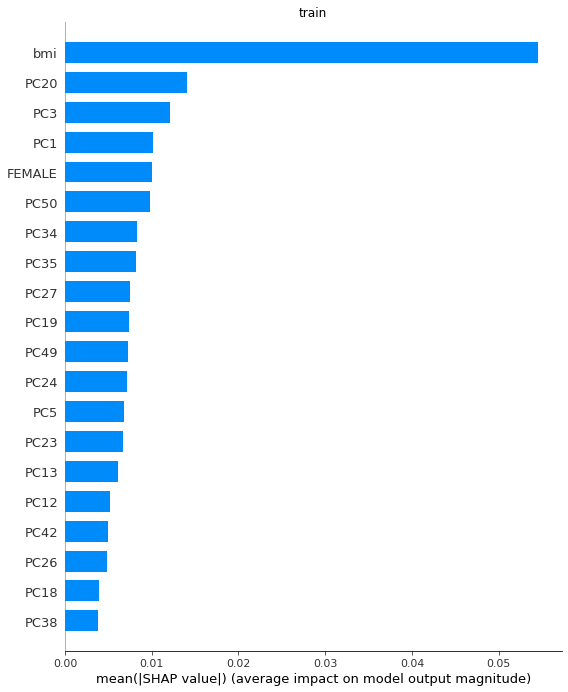

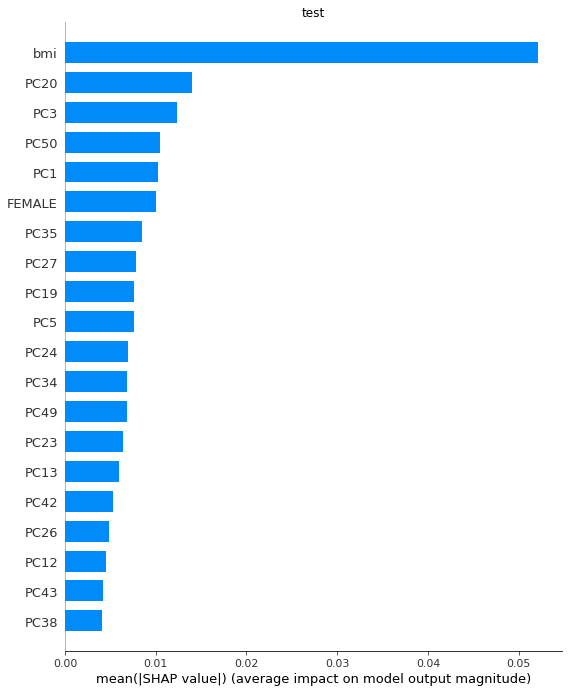

In [46]:
ft_test = pd.concat([X_test[['age', 'FEMALE', 'bmi']], pca_test[[f'PC{x}' for x in range(1, 51)]]], axis=1)
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

We still overfit, but better. What if we only select the featuers that were significant based on the shap values?
bmi, PC20, PC3, PC50, PC1, FEMALE

In [47]:
ft_train = pd.concat([X_train[['FEMALE', 'bmi']], pca_train[['PC20', 'PC3', 'PC50', 'PC1']]], axis=1)
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}

random_forest = RandomForestClassifier(random_state=42)
clf = RandomForestClassifier(random_state=42, **params)
clf.fit(ft_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

              precision    recall  f1-score   support

       False       0.94      0.69      0.79       175
        True       0.27      0.74      0.39        27

    accuracy                           0.69       202
   macro avg       0.61      0.71      0.59       202
weighted avg       0.85      0.69      0.74       202



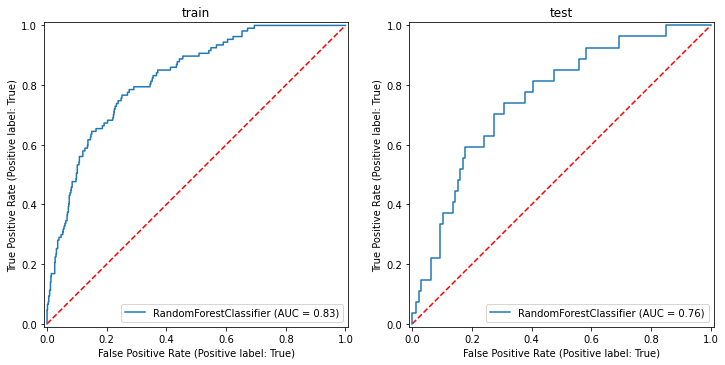

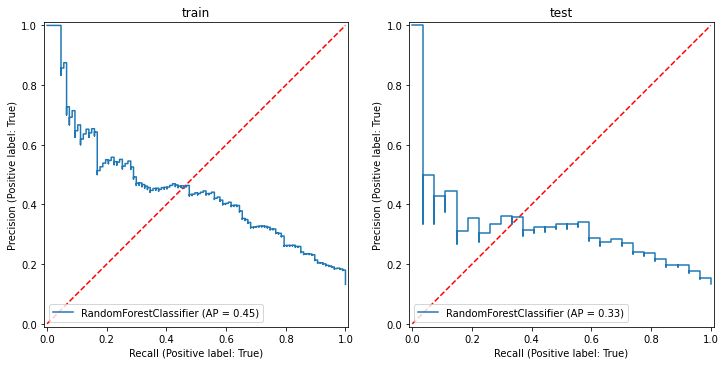

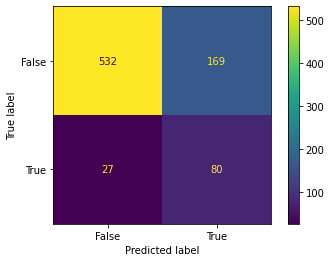

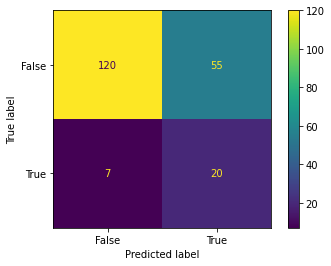

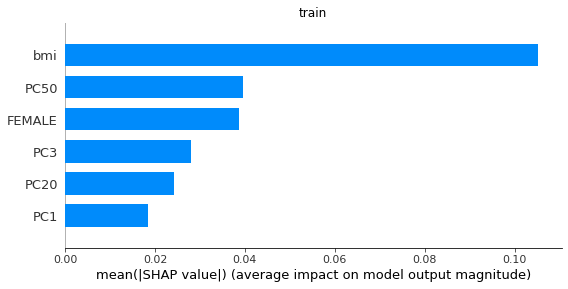

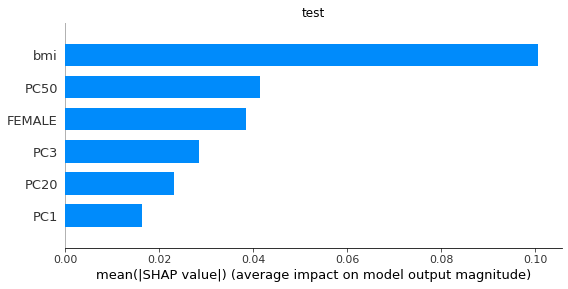

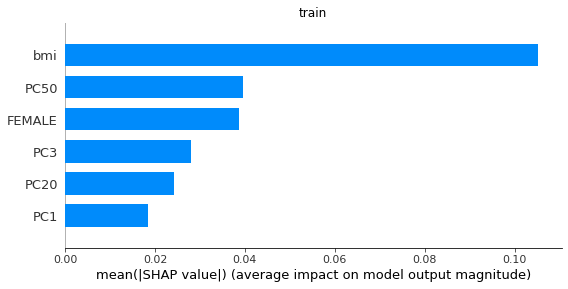

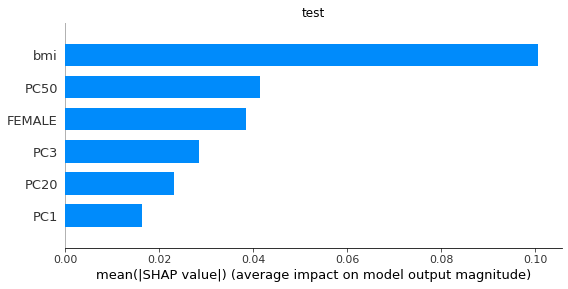

In [48]:
ft_test = pd.concat([X_test[['FEMALE', 'bmi']], pca_test[['PC20', 'PC3', 'PC50', 'PC1']]], axis=1)
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

Less overfit, but it still better just to use the baseline. So currently we have nothing.

## Predicting using taxa, adjust rare feature threshold to avoid overfitting

In [1]:
# todo

## Prediction using taxa (this time after CLR transformed):

In [ ]:
# todo 
# We want to avoid the case where we can identify each and every sample by the 

In [54]:
ft_train = X_train.loc[:, clr_taxa.columns]
random_forest = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'max_depth': [3, 10],
              'min_samples_split': [2, 10, 50],
              'min_samples_leaf': [2, 10, 50],
               'max_features': ['sqrt'],
             'class_weight': ['balanced']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(ft_train, y_train)

print(search.best_params_)

clf = RandomForestClassifier(random_state=42, **search.best_params_)
clf.fit(ft_train, y_train)


{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 100}


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=50,
                       random_state=42)

              precision    recall  f1-score   support

       False       0.87      0.99      0.93       175
        True       0.50      0.04      0.07        27

    accuracy                           0.87       202
   macro avg       0.69      0.52      0.50       202
weighted avg       0.82      0.87      0.81       202



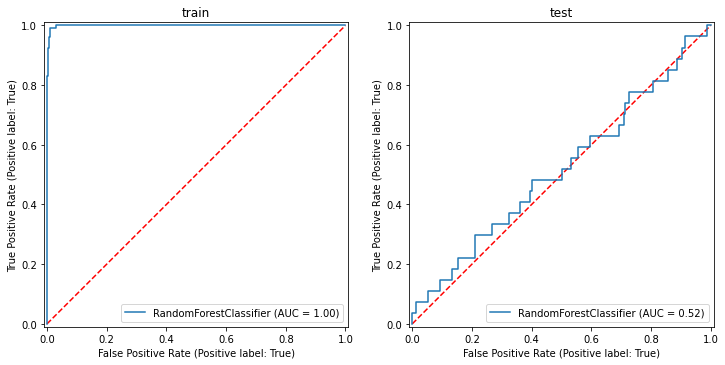

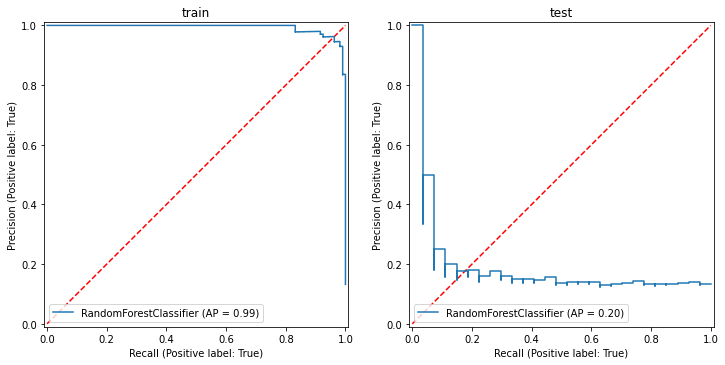

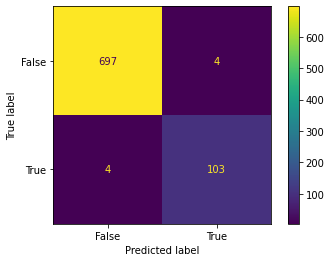

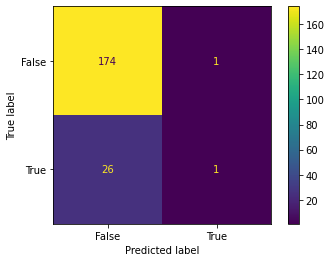

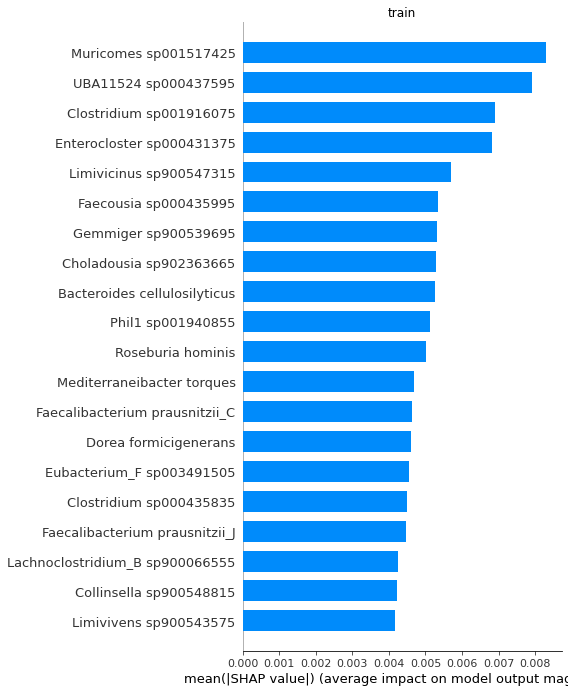

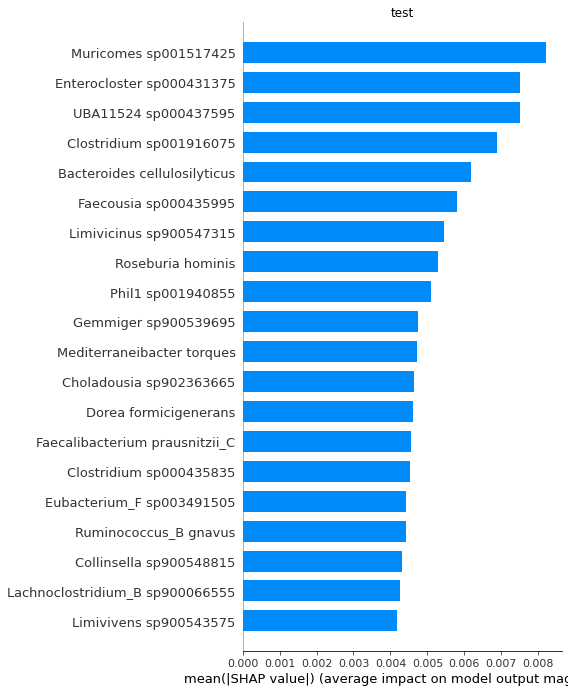

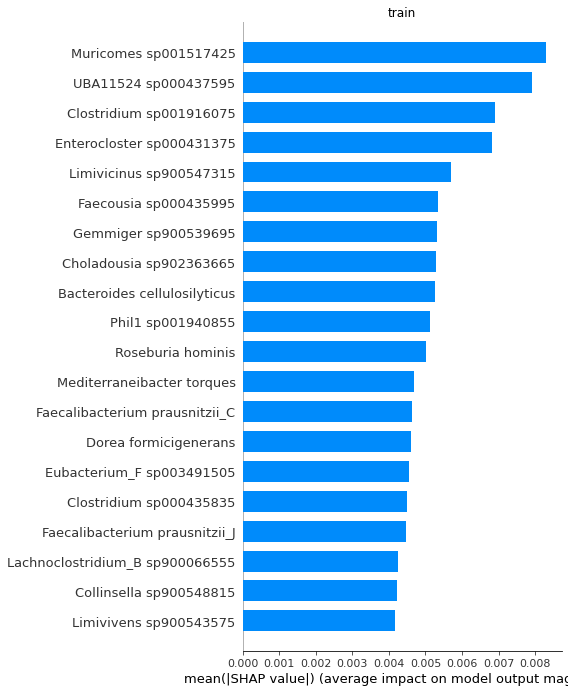

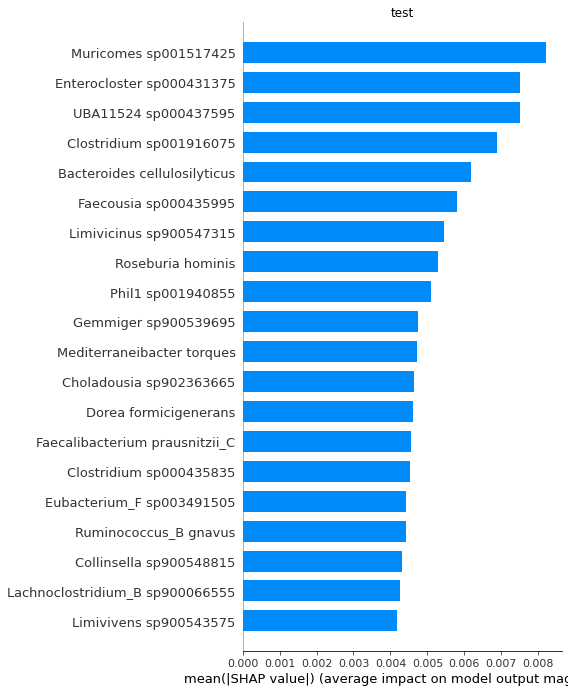

In [55]:
ft_test = X_test.loc[:, clr_taxa.columns]
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

Maybe the % of train-validation in the cv is not enough as it's still overfit so badly. 

Let's try manually setting the hyper-parameters:

In [56]:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'min_samples_leaf':30, 'n_estimators': 100}

clf = RandomForestClassifier(random_state=42, **params)
clf.fit(ft_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=30, min_samples_split=50,
                       random_state=42)

              precision    recall  f1-score   support

       False       0.87      0.85      0.86       175
        True       0.16      0.19      0.17        27

    accuracy                           0.76       202
   macro avg       0.52      0.52      0.52       202
weighted avg       0.78      0.76      0.77       202



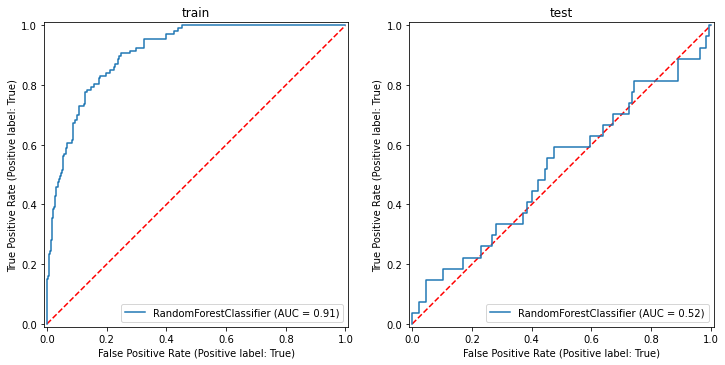

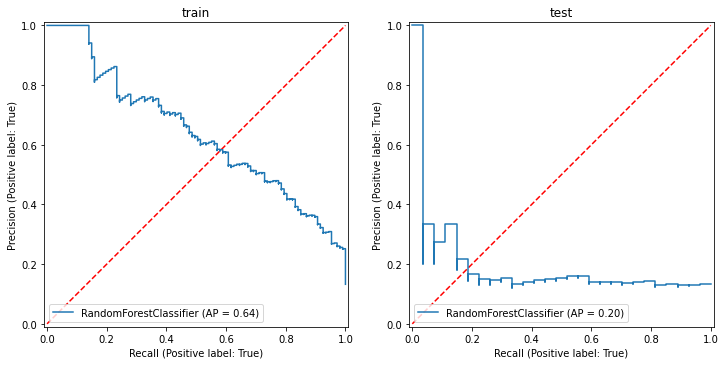

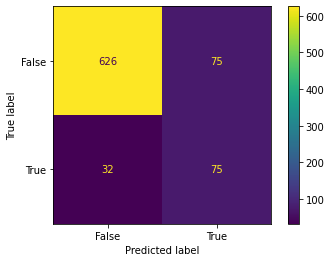

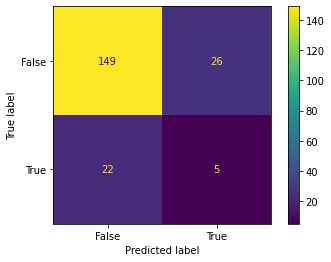

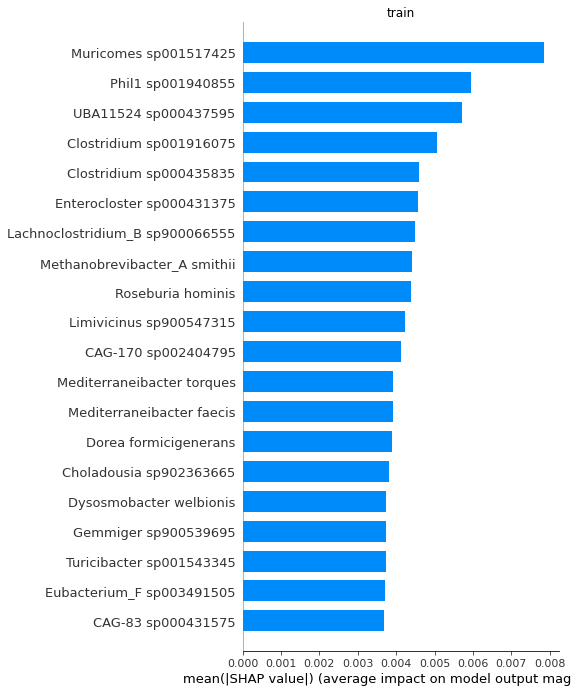

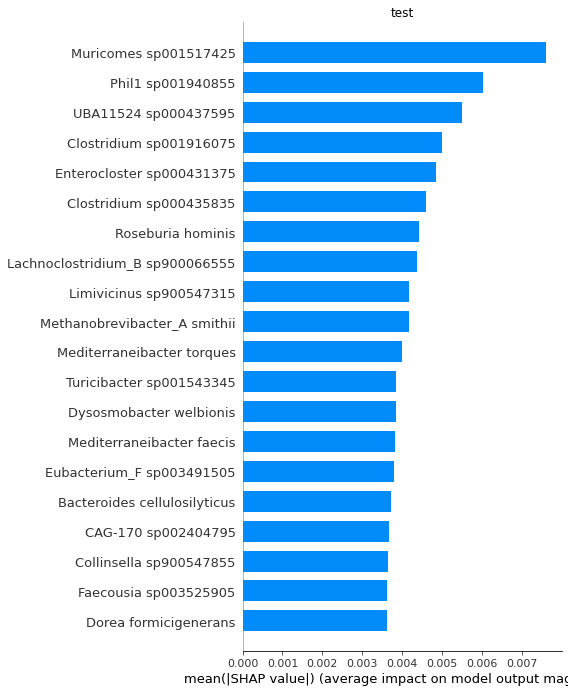

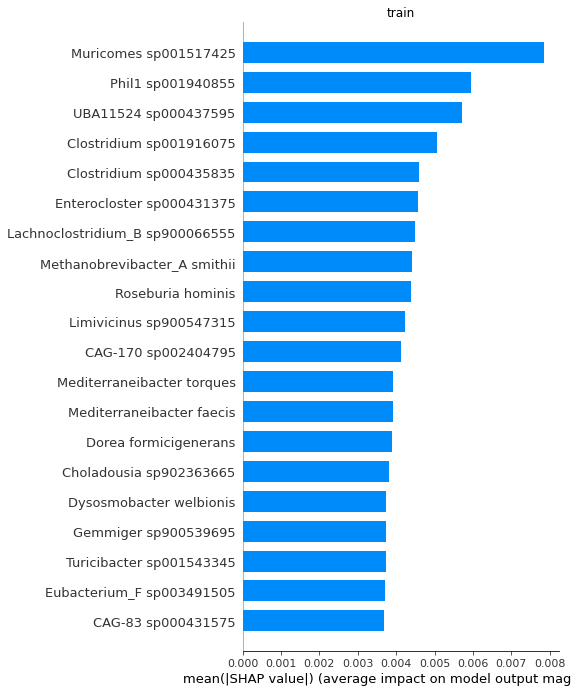

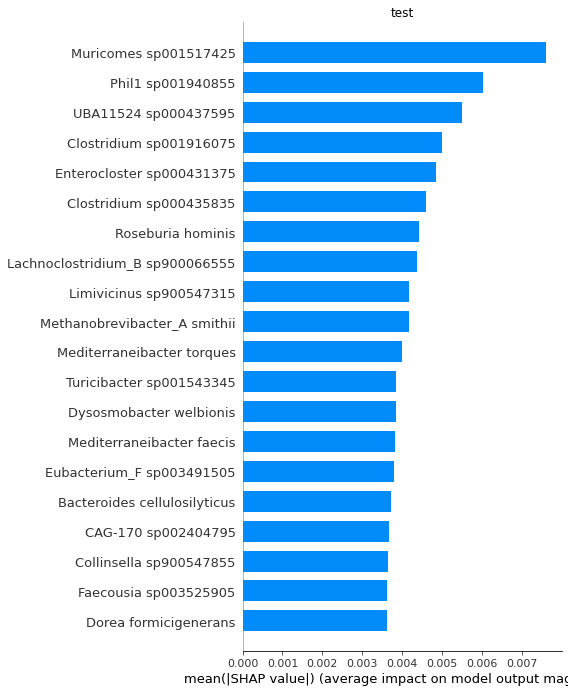

In [57]:
ft_test = X_test.loc[:, clr_taxa.columns]
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

We can see that basically there is not really a signal that the model was able to found using this data. 

## Predicting using taxa, selecting only high-correlated taxa 1

In [60]:
# todo

blood_measurments_microbiome_p_values_corrected= pd.read_pickle('results/blood_measurments_microbiome_p_values_corrected_spearmanr.pkl')
blood_measurments_microbiome_p_values = pd.read_pickle('results/blood_measurments_microbiome_p_values_spearmanr.pkl')
blood_measurments_microbiome_corr_coef = pd.read_pickle('results/blood_measurments_microbiome_corr_coef_spearmanr.pkl')

[Text(0.5, 1.0, 'Correlation coef of Blood Measurments & Microbiome')]

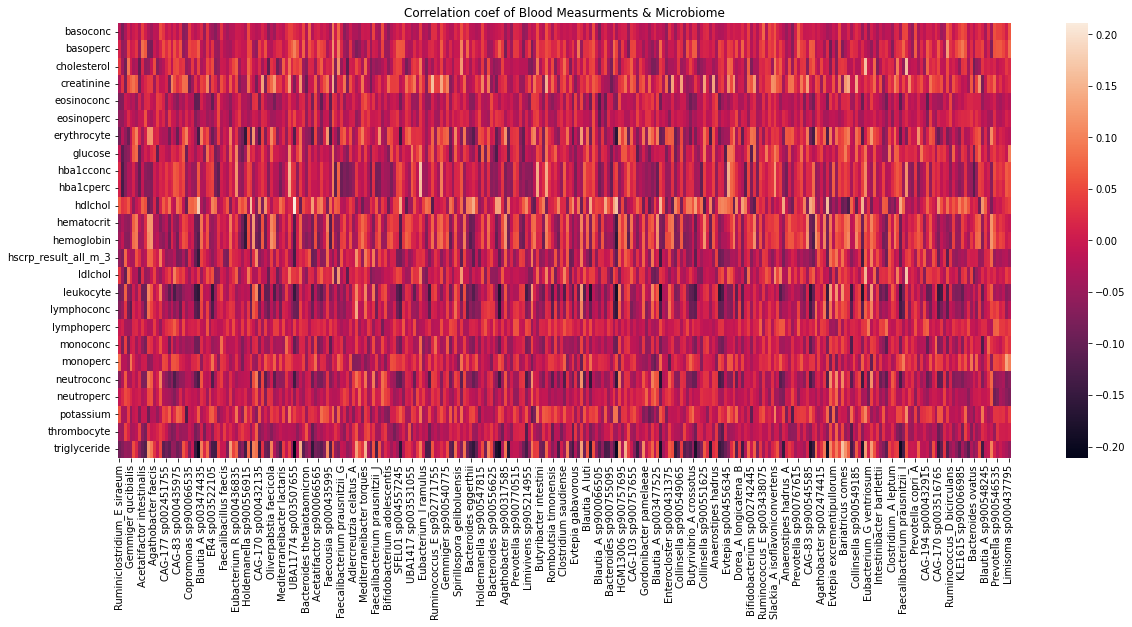

In [66]:
# TODO: Note, this is including lickage because the corr is both on train & test. Redo if it works.
fig, axes = plt.subplots(figsize=(20,8))
sns.heatmap(blood_measurments_microbiome_corr_coef.T.astype(float)).set(title='Correlation coef of Blood Measurments & Microbiome')

In [72]:
trig_taxa_corr_coef = blood_measurments_microbiome_corr_coef.T.loc['triglyceride', :].sort_values(ascending=False)

In [75]:
trig_taxa_corr_coef = trig_taxa_corr_coef.astype(float)
trig_taxa_corr_coef.nlargest(n=5)

Ruminococcus_B gnavus         0.165855
Mediterraneibacter torques    0.150377
Oliverpabstia intestinalis    0.145472
Bariatricus comes_A           0.144761
Dysosmobacter welbionis       0.130489
Name: triglyceride, dtype: float64

In [77]:
trig_taxa_corr_coef.nsmallest(n=5)

UBA11774 sp003507655   -0.211051
CAG-83 sp900548615     -0.199639
Phil1 sp001940855      -0.198250
ER4 sp900317525        -0.194063
UBA11524 sp000437595   -0.191597
Name: triglyceride, dtype: float64

In [78]:
specific_taxa = trig_taxa_corr_coef.nlargest(n=5).index.append(trig_taxa_corr_coef.nsmallest(n=5).index)

In [84]:
ft_train = X_train.loc[:, specific_taxa.append(pd.Index(['bmi','FEMALE']))]

params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}

clf = RandomForestClassifier(random_state=42, **params)
clf.fit(ft_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

              precision    recall  f1-score   support

       False       0.92      0.72      0.81       175
        True       0.25      0.59      0.35        27

    accuracy                           0.70       202
   macro avg       0.58      0.66      0.58       202
weighted avg       0.83      0.70      0.75       202



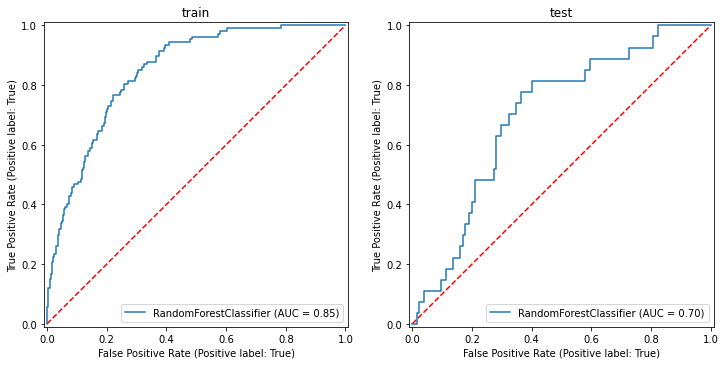

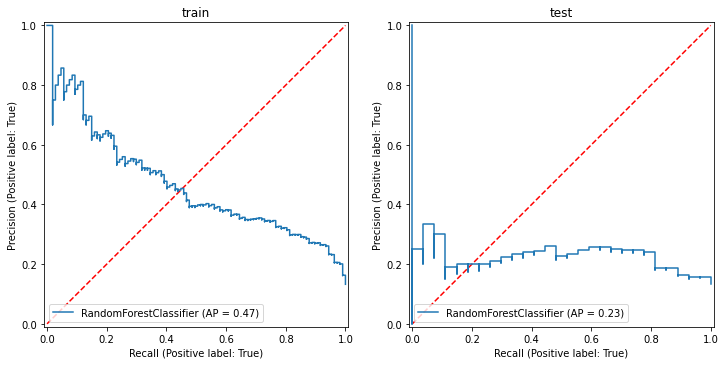

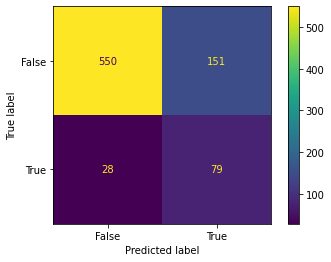

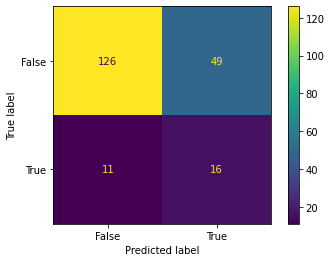

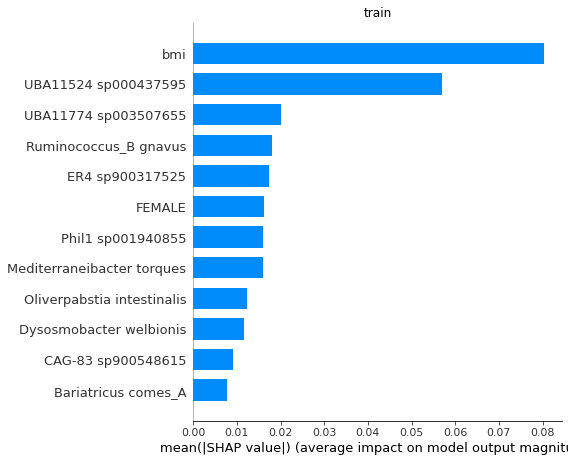

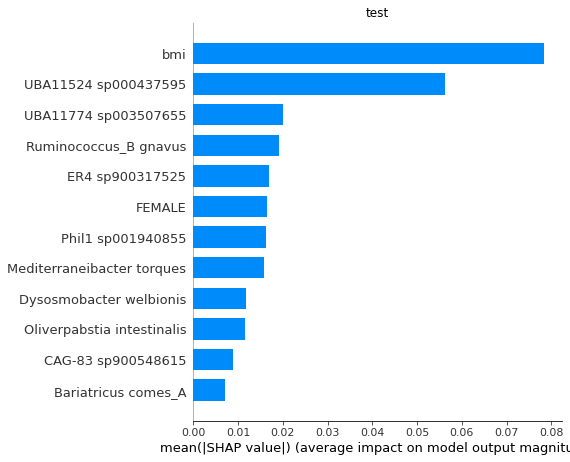

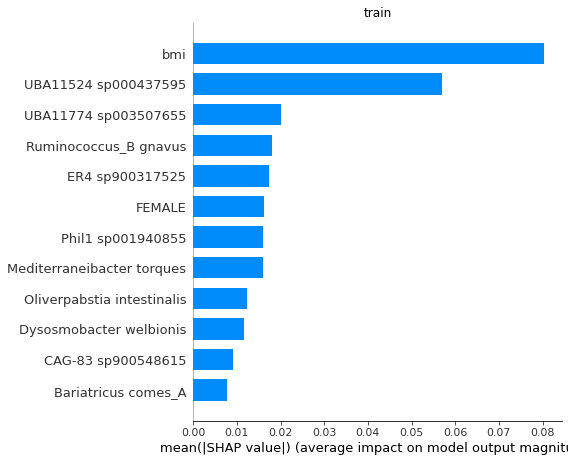

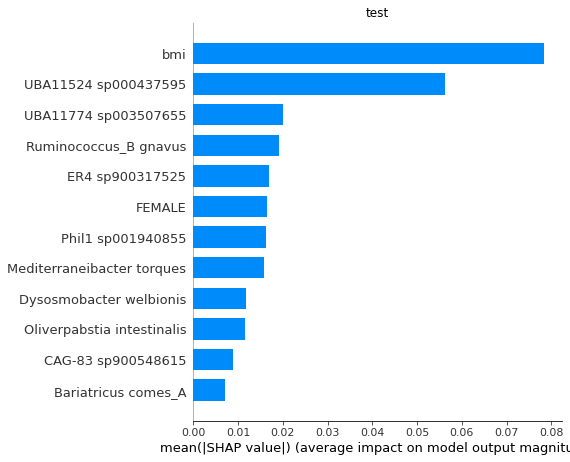

In [85]:
ft_test = X_test.loc[:, specific_taxa.append(pd.Index(['bmi','FEMALE']))]
evaluation.report_clf_preformance(clf=clf, X_train=ft_train, y_train=y_train, X_test=ft_test, y_test=y_test)

Still work less then baseline

## Predicting using taxa, selecting only high-correlated taxa 2

This time, we will look on correlation of the CLR transformed taxa with the log-trig!

Possibly on multiple taxononic levels (collapse RA to genus and family, and compete CLR) and assosiation. 

In [ ]:
# todo

## Feature engineering : Try to use prior knowledge about trig to get meaningful prediction 

In the model they used in Lifeline

Cleaning that lifeline did: 

"We excluded 99 samples from participants who were taking antibiotic or other potential microbiome-modifying drugs or who were on lipid-lowering medication."

TODO aswell. 

In [ ]:
# todo

following this approach from lifeline (attached below) consider aggregating to one column highely correlated taxa to one feature.

In [ ]:
# todo 

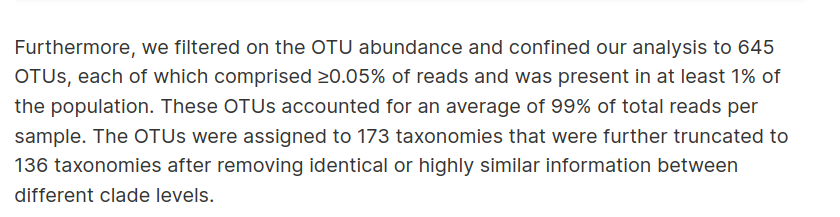

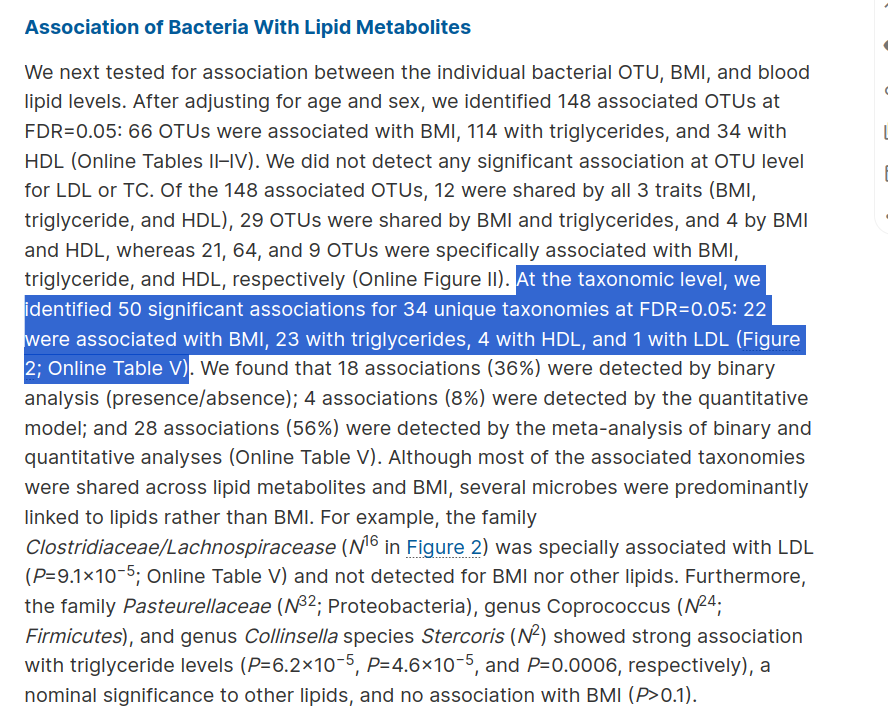

In [ ]:
# todo:

In [ ]:
# TODO: Diversity-within-clase

Extracting the specific taxa they find with significant association from their online table (note they used GreenGenes and different pipeline for taxonomic assignment).

Let's start by considering features realted to the family Pasteurellaceae, the genus Coprococcus, the genus Collinsella and the species Stercoris. 
(They are working in different levels of taxonomy in their assosiation analysis. This is an interesting perspective as well, we might need to consider. 
Also, maybe we can look at many different features: CLR, clade-diversity, prevalance/abundance etc and do feature selection using GLM with L1 regression.


In [ ]:
# todo:

In [86]:
X.shape

(1010, 308)

## What are the model preforamnce using the best taxa features only? (Without any metadata)